In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import sys
import numpy as np
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

from importlib import reload

import src.cathay_db as db
import src.utils as ut
import src.financial_statement as fs

reload(ut)
reload(fs)
import matplotlib.pyplot as plt
import datetime
import os
import xgboost as xgb
sys.path.append("./src")

from toolbox import print_progress_bar

# set max display rows
pd.set_option("display.max_rows", 200)

# set max display columns
pd.set_option("display.max_columns", 100)

# Set the float format to display without scientific notation
pd.options.display.float_format = '{:.4f}'.format

# Set Model

In [2]:
# select model 
model_folder_name = '20230719_083148'
# model_folder_name = '20230712_173216'
# model_folder_name = '20230711_171428'
# model_folder_name = '20230711_110457'
# model_folder_name = '20230707_140403'
# model_folder_name = '20230706_141045'

# load setting from data/model/model_folder_name/setting.json
setting = ut.load_json(f'./data/model/{model_folder_name}/setting.json')

print(setting.keys())
print(setting['factor_columns'])

dict_keys(['start_index', 'rebalance_date_lst', 'factor_columns', 'target_cols', 'model_save_path', 'param_search', 'fit_params'])
['asset_qoq', 'asset_yoy', 'ni_qoq', 'ni_yoy', 'roe', 'roe_yoy', 'roe_4q_sum', 'roe_4q_sum_yoy', 'tobins_q', 'ocf / asset', '20_d_return', '40_d_return', '60_d_return', 'dividend_1Y_sum_yield', 'dividend_2Y_sum_yield', 'dividend_3Y_sum_yield', 'last_dividend_yield']


In [3]:
df_adjusted_price = pd.read_feather('data/df_adjusted_price.feather')
df_adjusted_price.drop_duplicates(inplace=True)
df_adjusted_price.reset_index(drop=True, inplace=True)


,date,ticker,price,price_shift,rebalance_period_return
227,2004-03-15,2330,23.1519,19.0207,-0.1784
1340,2004-06-15,2330,19.0207,20.0824,0.0558
2476,2004-09-15,2330,20.0824,22.0287,0.0969
3616,2004-12-15,2330,22.0287,22.6037,0.0261
4775,2005-03-15,2330,22.6037,26.7305,0.1826


,date,ticker,price,price_shift
227,2004-03-15,2330,23.1519,19.0207
1340,2004-06-15,2330,19.0207,20.0824
2476,2004-09-15,2330,20.0824,22.0287
3616,2004-12-15,2330,22.0287,22.6037
4775,2005-03-15,2330,22.6037,26.7305


In [22]:
# create a list for model json file in model/model_folder_name
model_list = []
for model in os.listdir(f'./models/{model_folder_name}'):
    if model.endswith('.json'):
        # append the model path to model_list
        model_list.append(f'./models/{model_folder_name}/{model}')
# sort model_list
model_list.sort()

In [23]:
# load df_factor from data/model/model_folder_name/df_factor_all.feather
df_factor_all = pd.read_feather(f'./data/model/{model_folder_name}/df_factor_all.feather')

# create a dataframe for model mapping
df_model_mapping = pd.DataFrame()
df_model_mapping['rebalance_date'] = setting['rebalance_date_lst'][setting['start_index'] + 0:]
df_model_mapping['model_path'] = model_list
# convert rebalance_date to datetime
df_model_mapping['rebalance_date'] = pd.to_datetime(df_model_mapping['rebalance_date'])

# merge the df_model_mapping and df_factor_all
df_factor_all = pd.merge(df_factor_all, df_model_mapping, left_on='date', right_on='rebalance_date', how='left')
df_factor_all = df_factor_all.sort_values(['date','ticker']).reset_index(drop=True)
df_factor_all['model_path'].fillna(method='ffill', inplace=True)
df_factor_all['rebalance_date'].fillna(method='ffill', inplace=True)
df_factor_all.dropna(subset=['model_path'], inplace=True)

df_factor_all = df_factor_all.reset_index(drop=True)

df_rebalance_date = pd.DataFrame()
df_rebalance_date['date'] = setting['rebalance_date_lst']
# set date to datetime format
df_rebalance_date['date'] = pd.to_datetime(df_rebalance_date['date'])
df_backtest_return = pd.merge(df_rebalance_date, df_adjusted_price, how='left', left_on='date', right_on='年月日')[['date','股票代號','收盤價(元)']].copy()

df_backtest_return.rename(columns={'股票代號':'ticker'}, inplace=True)
df_backtest_return.rename(columns={'收盤價(元)':'price'}, inplace=True)
df_backtest_return['price'] = df_backtest_return['price'].astype(float)
df_backtest_return['price_shift'] = df_backtest_return.groupby('ticker', group_keys=False)['price'].shift(-1)
df_backtest_return['rebalance_period_return'] = df_backtest_return['price_shift'] / df_backtest_return['price'] - 1

df_factor_all = df_factor_all.merge(df_backtest_return[['date','ticker','rebalance_period_return']], on=['date','ticker'], how='left')

df_factor_all.to_feather(f'./data/model/{model_folder_name}/df_factor_all_select.feather')

In [27]:
factor_columns = setting['factor_columns']

In [35]:
model_list = df_factor_all['model_path'].unique()
reb_lst = df_factor_all['rebalance_date'].unique()

In [36]:
df_predict_all = pd.DataFrame([])
df_feature_importance_all = pd.DataFrame([])
for i, model_path in enumerate(model_list):
    model = xgb.Booster()
    model.load_model(model_path)
    try:
        df_feature_importance = pd.DataFrame(model.get_score(importance_type='gain').items(), columns=['feature','importance'])
        df_feature_importance.sort_values('importance', ascending=False, inplace=True)
        df_feature_importance['date'] = reb_lst[i]
        df_feature_importance_all = pd.concat([df_feature_importance_all, df_feature_importance], axis=0)

        df_predict = df_factor_all[df_factor_all['rebalance_date'] == reb_lst[i]].reset_index(drop=True).copy()
        df_predict['predict'] = model.predict(xgb.DMatrix(df_predict[factor_columns]))
        df_predict_all = pd.concat([df_predict_all, df_predict], axis=0)
    except:
        print(reb_lst)

In [43]:
df_feature_importance_des = df_feature_importance_all.groupby('feature')['importance'].describe().sort_values('mean', ascending=False).reset_index()
df_feature_importance_des['IR'] = df_feature_importance_des['50%'] / df_feature_importance_des['std']
# rank IR
df_feature_importance_des['mean_rank'] = df_feature_importance_des['mean'].rank(ascending=False)
df_feature_importance_des['IR_rank'] = df_feature_importance_des['IR'].rank(ascending=False)

df_feature_importance_des.sort_values('mean', ascending=False, inplace=True)
df_feature_importance_des

,feature,count,mean,std,min,25%,50%,75%,max,IR,mean_rank,IR_rank
0,roe,72.0000,129.2931,29.0219,81.6439,105.7983,122.7689,152.2346,185.4275,4.2302,1.0000,7.0000
1,ni_yoy,69.0000,92.5848,36.9257,25.8884,53.1995,102.8310,125.2072,148.9049,2.7848,2.0000,14.0000
2,tobins_q,72.0000,90.7967,34.0442,33.1311,62.4043,88.3939,124.9307,146.3965,2.5964,3.0000,15.0000
3,last_dividend_yield,72.0000,87.8232,14.4876,45.8703,84.9974,92.5041,96.4299,108.8885,6.3851,4.0000,1.0000
4,roe_4q_sum,69.0000,79.3873,15.1367,39.2368,71.8969,84.2529,90.0139,105.7890,5.5661,5.0000,2.0000
5,60_d_return,72.0000,78.2667,30.5038,30.7428,53.3122,74.8509,95.0571,152.1602,2.4538,6.0000,16.0000
6,dividend_1Y_sum_yield,71.0000,75.8732,42.3117,13.9206,37.5700,77.2768,109.6611,170.4933,1.8264,7.0000,17.0000
7,roe_yoy,70.0000,74.6743,27.5687,11.6989,46.5482,82.6170,96.8557,129.3008,2.9968,8.0000,13.0000
8,40_d_return,72.0000,68.4778,13.4379,39.0896,57.5964,69.2749,78.9969,94.6772,5.1552,9.0000,5.0000
9,20_d_return,72.0000,67.6521,15.6227,40.4147,54.6327,65.8863,75.0778,103.6699,4.2173,10.0000,8.0000


In [44]:
i = 0

df_predict_describe_all = pd.DataFrame([])

for i in range(len(reb_lst)):
    df_predict = df_predict_all[df_predict_all['rebalance_date'] == reb_lst[i]].reset_index(drop=True).copy()
    # calc predict qcut
    df_predict['predict_qcut'] = pd.qcut(df_predict['predict'], 10, labels=False, duplicates='drop')
    # df_predict_describe = df_predict.groupby('predict_qcut')['y'].describe().reset_index()
    df_predict_describe = df_predict.groupby('predict_qcut')['rebalance_period_return'].describe().reset_index()
    df_predict_describe['date'] = reb_lst[i]
    df_predict_describe_all = pd.concat([df_predict_describe_all, df_predict_describe], axis=0)

In [45]:
df_predict_describe_all.groupby('predict_qcut')['mean'].describe().sort_values('mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
predict_qcut,,,,,,,,
9,72.0000,0.0536,0.1187,-0.2880,0.0115,0.0565,0.1075,0.3423
8,72.0000,0.0501,0.1080,-0.2389,0.0105,0.0587,0.0982,0.3275
7,72.0000,0.0448,0.1165,-0.2661,-0.0085,0.0516,0.1142,0.3323
6,72.0000,0.0435,0.1169,-0.2701,-0.0096,0.0287,0.0974,0.3261
5,72.0000,0.0369,0.1150,-0.2801,-0.0045,0.0403,0.0925,0.3224
4,72.0000,0.0356,0.1177,-0.2582,-0.0140,0.0304,0.0943,0.3760
3,72.0000,0.0320,0.1148,-0.2935,-0.0208,0.0323,0.0881,0.3369
2,72.0000,0.0301,0.1251,-0.2854,-0.0334,0.0405,0.0818,0.4681
1,72.0000,0.0296,0.1352,-0.3005,-0.0345,0.0282,0.0793,0.5132


In [46]:
df_predict_all = df_predict_all[df_predict_all['date'].isin(reb_lst)]
# df_predict_all['predict_group'] = df_predict_all.groupby('rebalance_date',group_keys=False)['predict'].apply(lambda x :pd.qcut(x, 5, labels=False))
df_predict_all['predict_rank'] = df_predict_all.groupby('rebalance_date',group_keys=False)['predict'].rank(ascending=False)
df_select = df_predict_all[df_predict_all['predict_rank']<=50]
# df_select_return = df_select.groupby('date')['y'].mean()
df_select_return = df_select.groupby('date')['rebalance_period_return'].mean()


def calculate_cagr(df):
    # Add 1 to all the quarterly returns
    df_plus_one = df + 1
    # Calculate the cumulative product of the returns
    cum_product = df_plus_one.cumprod()
    # Get the total number of years
    num_years = len(df) / 4
    # Calculate CAGR
    cagr = (cum_product.iloc[-1])**(1/num_years) - 1
    return cagr


In [47]:
print(f"SR: {((df_select_return + 1).prod()**(4/len(df_select_return)) -1 ) / (df_select_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_return.std() * np.sqrt(4)):.2%}")

SR: 0.85
CAGR: 21.25%
Std: 25.03%


In [48]:
# follow code is not used because the top stocks is select by last dividend yield and predict_rank, 
# the result will fulfill the requirement (dividend yield >= 5% and predict_rank <= certain rank)

# dividend_min = 0.05
# df_dividend_filter = df_predict_all[df_predict_all['last_dividend_yield'] >= dividend_min].copy()
# df_predict_filter = df_predict_all[df_predict_all['predict_rank'] <= 300]
# df_dividend_select = pd.concat([df_dividend_filter, df_predict_filter]).drop_duplicates().reset_index(drop=True)
# df_dividend_select.sort_values(['date','ticker'], inplace=True)

# Consider Market Cap

In [49]:
# df_market_cap_melt.to_feather('./data/df_market_cap_melt.feather')
df_market_cap_melt = pd.read_feather('./data/df_market_cap_melt.feather')
df_predict_merge_cap = df_predict_all.merge(df_market_cap_melt, on=['date','ticker'], how='left').copy()
df_predict_merge_cap['market_cap_rank'] = df_predict_merge_cap.groupby('date',group_keys=False)['market_cap'].rank(ascending=False)
df_predict_merge_cap = df_predict_merge_cap[df_predict_merge_cap['market_cap_rank'] <= 300].copy()

# Consider Liquidity

In [50]:
# df_price_liquidity_flag.to_feather('./data/df_price_liquidity_flag.feather')
df_price_liquidity_flag = pd.read_feather('./data/df_price_liquidity_flag.feather')
df_price_liquidity_flag = df_price_liquidity_flag[['日期','股票代號','flag_all']]
df_price_liquidity_flag.columns = ['date','ticker','flag_all']


df_predict_merge_cap = pd.merge(df_predict_merge_cap, df_price_liquidity_flag, on=['date','ticker'], how='left')
df_select_pool = df_predict_merge_cap[df_predict_merge_cap['flag_all'] != 1].reset_index(drop=True).copy()


In [51]:
def top_n(df, n=5, columns=['last_dividend_yield', 'predict_rank'], ascending=[False, True]):
    return df.sort_values(by=columns, ascending=ascending).head(n)

df_select_pool = df_select_pool.reset_index(drop=True)
df_select_pool_top_50 = df_select_pool.groupby('date').apply(top_n, n=50, columns=['last_dividend_yield', 'predict_rank'], ascending=[False, True])

df_select_pool_top_50.reset_index(drop=True, inplace=True)
# df_select_pool_top_50_return = df_select_pool_top_50.groupby('date')['y'].mean()
df_select_pool_top_50_return = df_select_pool_top_50.groupby('date')['rebalance_period_return'].mean()
print("不做選股Buffer | 依次排序 1.股利率 2.模型預測")
print(f"SR: {((df_select_pool_top_50_return + 1).prod() ** (4/len(df_select_pool_top_50_return)) -1 ) / (df_select_pool_top_50_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_pool_top_50_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_pool_top_50_return.std() * np.sqrt(4)):.2%}")


不做選股Buffer | 依次排序 1.股利率 2.模型預測
SR: 0.59
CAGR: 12.55%
Std: 21.18%


In [52]:
df_select_pool = df_select_pool.reset_index(drop=True)
df_select_pool_top_50 = df_select_pool.groupby('date').apply(top_n, n=50, columns=['predict_rank'], ascending=[True])

df_select_pool_top_50.reset_index(drop=True, inplace=True)
# df_select_pool_top_50_return = df_select_pool_top_50.groupby('date')['y'].mean()
df_select_pool_top_50_return = df_select_pool_top_50.groupby('date')['rebalance_period_return'].mean()
print("不做選股Buffer | 只排序 1.模型預測")
print(f"SR: {((df_select_pool_top_50_return + 1).prod() ** (4/len(df_select_pool_top_50_return)) -1 ) / (df_select_pool_top_50_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_pool_top_50_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_pool_top_50_return.std() * np.sqrt(4)):.2%}")


不做選股Buffer | 只排序 1.模型預測
SR: 0.71
CAGR: 15.20%
Std: 21.46%


In [53]:
df_select_pool_benchmark = df_select_pool.groupby('date').apply(top_n, n=50, columns=['market_cap_rank'], ascending=[True])

df_select_pool_benchmark.reset_index(drop=True, inplace=True)
# df_select_pool_benchmark_return = df_select_pool_benchmark.groupby('date')['y'].mean()
df_select_pool_benchmark_return = df_select_pool_benchmark.groupby('date')['rebalance_period_return'].mean()
print("Pool 不做選股Buffer | 只排序 1.市值")
print(f"SR: {((df_select_pool_benchmark_return + 1).prod() ** (4/len(df_select_pool_benchmark_return)) -1 ) / (df_select_pool_benchmark_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_pool_benchmark_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_pool_benchmark_return.std() * np.sqrt(4)):.2%}")

df_select_pool_benchmark.to_feather(f'./data/model/{model_folder_name}/df_select_pool_benchmark.feather')

Pool 不做選股Buffer | 只排序 1.市值
SR: 0.42
CAGR: 7.71%
Std: 18.29%


In [54]:
df_select_pool.to_feather(f'./data/model/{model_folder_name}/df_select_pool.feather')

# Pre-filtering the dividend yield

In [55]:
# df_market_cap_melt.to_feather('./data/df_market_cap_melt.feather')
df_market_cap_melt = pd.read_feather('./data/df_market_cap_melt.feather')
df_predict_merge_cap = df_predict_all.merge(df_market_cap_melt, on=['date','ticker'], how='left').copy()
df_predict_merge_cap['market_cap_rank'] = df_predict_merge_cap.groupby('date',group_keys=False)['market_cap'].rank(ascending=False)
df_predict_merge_cap = df_predict_merge_cap[df_predict_merge_cap['market_cap_rank'] <= 300].copy()

df_filter_dividends_yield = df_predict_merge_cap[df_predict_merge_cap['dividend_1Y_sum_yield'] > 0.04].copy()

## Consider Liquidity

In [56]:
# df_price_liquidity_flag.to_feather('./data/df_price_liquidity_flag.feather')
df_price_liquidity_flag = pd.read_feather('./data/df_price_liquidity_flag.feather')
df_price_liquidity_flag = df_price_liquidity_flag[['日期','股票代號','flag_all']]
df_price_liquidity_flag.columns = ['date','ticker','flag_all']

df_filter_dividends_yield = pd.merge(df_filter_dividends_yield, df_price_liquidity_flag, on=['date','ticker'], how='left')
df_select_filter_dividends_yield = df_filter_dividends_yield[df_filter_dividends_yield['flag_all'] != 1].reset_index(drop=True).copy()
print(df_select_filter_dividends_yield.groupby('date')['y'].count().describe())

df_select_filter_dividends_yield = df_select_filter_dividends_yield.reset_index(drop=True)
df_select_filter_dividends_yield_top_50 = df_select_filter_dividends_yield.groupby('date').apply(top_n, n=50, columns=['predict_rank'], ascending=[True])

df_select_filter_dividends_yield_top_50.reset_index(drop=True, inplace=True)
# df_select_filter_dividends_yield_top_50_return = df_select_filter_dividends_yield_top_50.groupby('date')['y'].mean()
df_select_filter_dividends_yield_top_50_return = df_select_filter_dividends_yield_top_50.groupby('date')['rebalance_period_return'].mean()
print("不做選股Buffer | 只排序 1.模型預測")
print(f"SR: {((df_select_filter_dividends_yield_top_50_return + 1).prod() ** (4/len(df_select_filter_dividends_yield_top_50_return)) -1 ) / (df_select_filter_dividends_yield_top_50_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_filter_dividends_yield_top_50_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_filter_dividends_yield_top_50_return.std() * np.sqrt(4)):.2%}")


count    72.0000
mean    139.5417
std      37.4034
min      61.0000
25%     111.2500
50%     145.5000
75%     162.2500
max     239.0000
Name: y, dtype: float64
不做選股Buffer | 只排序 1.模型預測
SR: 0.83
CAGR: 15.70%
Std: 18.96%


In [57]:
df_select_filter_dividends_yield_top_50.to_feather(f'./data/model/{model_folder_name}/df_select_filter_dividends_yield_top_50.feather')

In [58]:
df_select_filter_dividends_yield_benchmark = df_select_filter_dividends_yield.groupby('date').apply(top_n, n=50, columns=['market_cap_rank'], ascending=[True])

df_select_filter_dividends_yield_benchmark.reset_index(drop=True, inplace=True)
# df_select_filter_dividends_yield_benchmark_return = df_select_filter_dividends_yield_benchmark.groupby('date')['y'].mean()
df_select_filter_dividends_yield_benchmark_return = df_select_filter_dividends_yield_benchmark.groupby('date')['rebalance_period_return'].mean()
print("Pool 不做選股Buffer | 只排序 1.市值")
print(f"SR: {((df_select_filter_dividends_yield_benchmark_return + 1).prod() ** (4/len(df_select_filter_dividends_yield_benchmark_return)) -1 ) / (df_select_filter_dividends_yield_benchmark_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_select_filter_dividends_yield_benchmark_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_select_filter_dividends_yield_benchmark_return.std() * np.sqrt(4)):.2%}")


Pool 不做選股Buffer | 只排序 1.市值
SR: 0.49
CAGR: 8.90%
Std: 18.25%


In [60]:
df_select_filter_dividends_yield_benchmark.to_feather(f'./data/model/{model_folder_name}/df_select_filter_dividends_yield_benchmark.feather')

# Restrict Turnover

In [61]:
apply_restrict_index = 1
base_portfolio_number = 50
restrict_turnover = 0.2

remain_number =  int(np.ceil(base_portfolio_number * (1 - restrict_turnover)))

# round up the restrict_portfolio_number
restrict_portfolio_number =  (base_portfolio_number * 2 - remain_number)

df_select_pool = df_select_filter_dividends_yield.reset_index(drop=True)
# get the base portfolio by base_portfolio_number 
df_select_pool_base = df_select_pool.groupby('date').apply(top_n, n = base_portfolio_number, columns=['predict_rank'], ascending=[True]).reset_index(drop=True)
# get the restrict portfolio by restrict_portfolio_number
df_select_pool_restrict = df_select_pool
df_select_pool_restrict.reset_index(drop=True, inplace=True)

apply_restrict_date = np.sort(reb_lst)[apply_restrict_index]
# string format
apply_restrict_date = pd.to_datetime(apply_restrict_date).strftime('%Y-%m-%d')
print(f'自 {apply_restrict_date} 開始使用 restrict 建構投組')

df_restrict_result = pd.DataFrame([])
# concat the data that date is smaller than apply_restrict_date to df_restrict_result
df_restrict_result = pd.concat([df_restrict_result, df_select_pool_base[df_select_pool_base['date'] < apply_restrict_date]], axis=0)
# print the max date in df_restrict_result
print(f"df_restrict_result['date'].max(): {df_restrict_result['date'].max()}")


for i in range(apply_restrict_index, len(reb_lst)):
# i = 1

    # get the slice data by reb_lst[i] in df_select_pool_restrict
    df_select_pool_restrict_temp = df_select_pool_restrict[df_select_pool_restrict['rebalance_date'] == reb_lst[i]].reset_index(drop=True)

    # get the slice data by reb_lst[i-1] in df_restrict_result, [i-1] is because we need to get the last portfolio
    df_restrict_result_temp = df_restrict_result[df_restrict_result['rebalance_date'] == reb_lst[i - 1]].reset_index(drop=True)

    # prepare the dataframe for finding the joint ticker
    df_new_temp = df_select_pool_restrict_temp[['date','ticker','predict', 'dividend_1Y_sum_yield']].copy()
    df_new_temp['restrict'] = 1
    df_new_temp.sort_values(['predict','dividend_1Y_sum_yield'], ascending=False, inplace=True)
    df_new_temp.reset_index(drop=True, inplace=True)

    last_portfolio_ticker_list = df_restrict_result_temp['ticker'].unique()

    df_priority_temp = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(last_portfolio_ticker_list)].copy()
    df_priority_temp.sort_values(['predict','dividend_1Y_sum_yield'], ascending=False, inplace=True)
    df_priority_temp.reset_index(drop=True, inplace=True)
    df_priority = df_priority_temp.head(remain_number)


    df_added = df_new_temp[df_new_temp['ticker'].isin(df_priority['ticker'].unique()) == False].head(base_portfolio_number - len(df_priority)).reset_index(drop=True)
    df_triviality = df_select_pool_restrict_temp[df_select_pool_restrict_temp['ticker'].isin(df_added['ticker'].unique())].reset_index(drop=True)

    df_restrict_result_temp = pd.concat([df_priority, df_triviality], axis=0)

    # concat the df_restrict_result_temp to df_restrict_result
    df_restrict_result = pd.concat([df_restrict_result, df_restrict_result_temp], axis=0)

df_restrict_result.reset_index(drop=True, inplace=True)
# df_restrict_result_return = df_restrict_result.groupby('date')['y'].mean()
df_restrict_result_return = df_restrict_result.groupby('date')['rebalance_period_return'].mean()

print(f'./data/model/{model_folder_name}/df_restrict_result_{apply_restrict_index}_{base_portfolio_number}_{restrict_portfolio_number}')
df_restrict_result.to_feather(f'./data/model/{model_folder_name}/df_restrict_result_{apply_restrict_index}_{base_portfolio_number}_{restrict_portfolio_number}.feather')
print(f"SR: {((df_restrict_result_return + 1).prod()**(4/len(df_restrict_result_return)) -1 ) / (df_restrict_result_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_restrict_result_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_restrict_result_return.std() * np.sqrt(4)):.2%}")


自 2005-06-15 開始使用 restrict 建構投組
df_restrict_result['date'].max(): 2005-03-15 00:00:00
./data/model/20230719_083148/df_restrict_result_1_50_60
SR: 0.67
CAGR: 12.68%
Std: 18.98%


# Compare with benchmarks

In [118]:
df_restrict_portfolio = pd.DataFrame(df_restrict_result_return).reset_index()
df_restrict_portfolio.columns = ['date','restrict_portfolio']
df_restrict_portfolio['restrict_portfolio'] = df_restrict_portfolio['restrict_portfolio'] + 1

df_portfolio = pd.DataFrame(df_select_filter_dividends_yield_top_50_return).reset_index()
df_portfolio.columns = ['date','ai_portfolio']
df_portfolio['ai_portfolio'] = df_portfolio['ai_portfolio'] + 1


In [128]:
df_benchmarks_all = pd.read_excel('./data/benchmarks.xlsx')

In [136]:
df_benchmarks_all.head(11)

,日期,TWA02,00878,00713,00900
0,2023/07/19,36511.3300,20.9600,46.1800,13.1800
1,2023/07/18,36741.4700,21.4300,46.9500,13.3700
2,2023/07/17,36958.9100,21.2800,46.9000,13.4600
3,2023/07/14,36840.8100,21.0100,46.3300,13.4400
4,2023/07/13,36359.2100,20.5300,45.8200,13.0900
5,2023/07/12,36113.9500,20.1900,45.5100,12.8600
6,2023/07/11,35967.6400,19.8000,45.3500,12.6600
7,2023/07/10,35416.0500,19.3100,44.8000,12.3800
8,2023/07/07,35432.9500,19.3100,44.9400,12.4000
9,2023/07/06,35636.7100,19.4900,45.2600,12.5000


<Axes: >

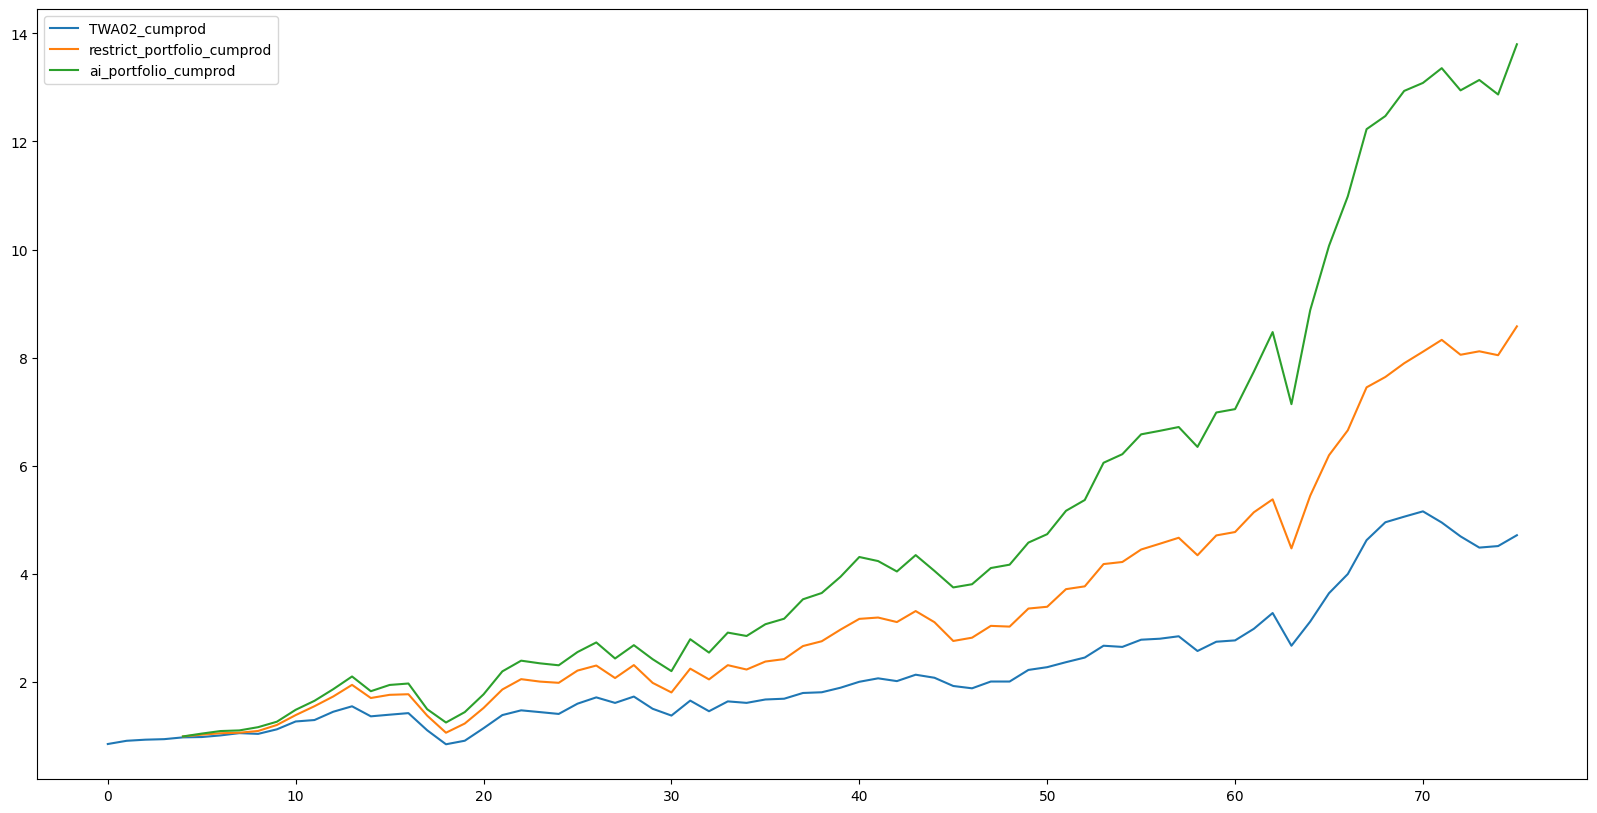

In [143]:
df_benchmarks_temp = df_benchmarks_all[['日期','TWA02']].copy()
df_benchmarks_temp.columns = ['date','TWA02']
df_benchmarks_temp.dropna(inplace=True)
# change the date format to datetime
df_benchmarks_temp['date'] = pd.to_datetime(df_benchmarks_temp['date'], format='%Y/%m/%d')
df_benchmarks_temp.sort_values('date', inplace=True)
df_benchmarks = pd.merge(df_rebalance_date, df_benchmarks_temp, on='date', how='left')

df_benchmarks.dropna(inplace=True)
df_benchmarks.reset_index(drop=True, inplace=True)
df_benchmarks['TWA02_adj'] = df_benchmarks['TWA02'] / df_benchmarks['TWA02'].iloc[0]
df_benchmarks['TWA02'] = df_benchmarks['TWA02'].astype(float)
# shift -1 for calculate the return
df_benchmarks['TWA02_shift'] = df_benchmarks['TWA02'].shift(-1)
df_benchmarks['TWA02_return'] = df_benchmarks['TWA02_shift'] / df_benchmarks['TWA02']

df_benchmarks = df_benchmarks.merge(df_restrict_portfolio, on='date', how='left')
df_benchmarks = df_benchmarks.merge(df_portfolio, on='date', how='left')
df_benchmarks['TWA02_cumprod'] = df_benchmarks['TWA02_return'].cumprod()
df_benchmarks['restrict_portfolio_cumprod'] = df_benchmarks['restrict_portfolio'].cumprod()
df_benchmarks['ai_portfolio_cumprod'] = df_benchmarks['ai_portfolio'].cumprod()

df_benchmarks[['TWA02_cumprod','restrict_portfolio_cumprod','ai_portfolio_cumprod']].plot(figsize=(20,10))

<Axes: >

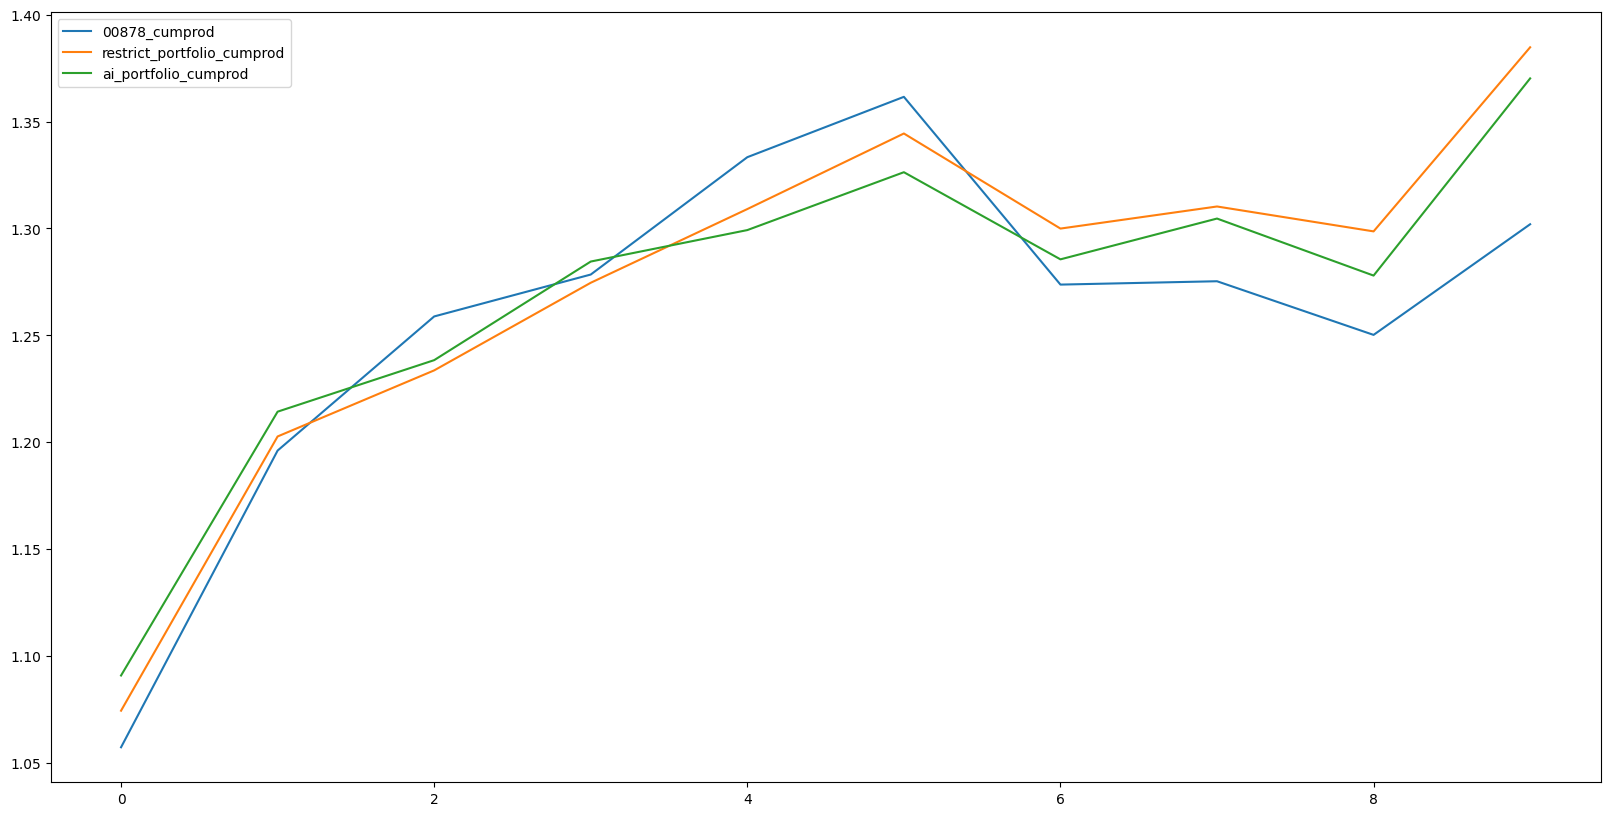

In [140]:
df_benchmarks_temp = df_benchmarks_all[['日期','00878']].copy()
df_benchmarks_temp.columns = ['date','00878']
df_benchmarks_temp.dropna(inplace=True)
# change the date format to datetime
df_benchmarks_temp['date'] = pd.to_datetime(df_benchmarks_temp['date'], format='%Y/%m/%d')
df_benchmarks_temp.sort_values('date', inplace=True)
df_benchmarks = pd.merge(df_rebalance_date, df_benchmarks_temp, on='date', how='left')

df_benchmarks.dropna(inplace=True)
df_benchmarks.reset_index(drop=True, inplace=True)
df_benchmarks['00878_adj'] = df_benchmarks['00878'] / df_benchmarks['00878'].iloc[0]
df_benchmarks['00878'] = df_benchmarks['00878'].astype(float)
# shift -1 for calculate the return
df_benchmarks['00878_shift'] = df_benchmarks['00878'].shift(-1)
df_benchmarks['00878_return'] = df_benchmarks['00878_shift'] / df_benchmarks['00878']

df_benchmarks = df_benchmarks.merge(df_restrict_portfolio, on='date', how='left')
df_benchmarks = df_benchmarks.merge(df_portfolio, on='date', how='left')
df_benchmarks['00878_cumprod'] = df_benchmarks['00878_return'].cumprod()
df_benchmarks['restrict_portfolio_cumprod'] = df_benchmarks['restrict_portfolio'].cumprod()
df_benchmarks['ai_portfolio_cumprod'] = df_benchmarks['ai_portfolio'].cumprod()

df_benchmarks[['00878_cumprod','restrict_portfolio_cumprod','ai_portfolio_cumprod']].plot(figsize=(20,10))

<Axes: >

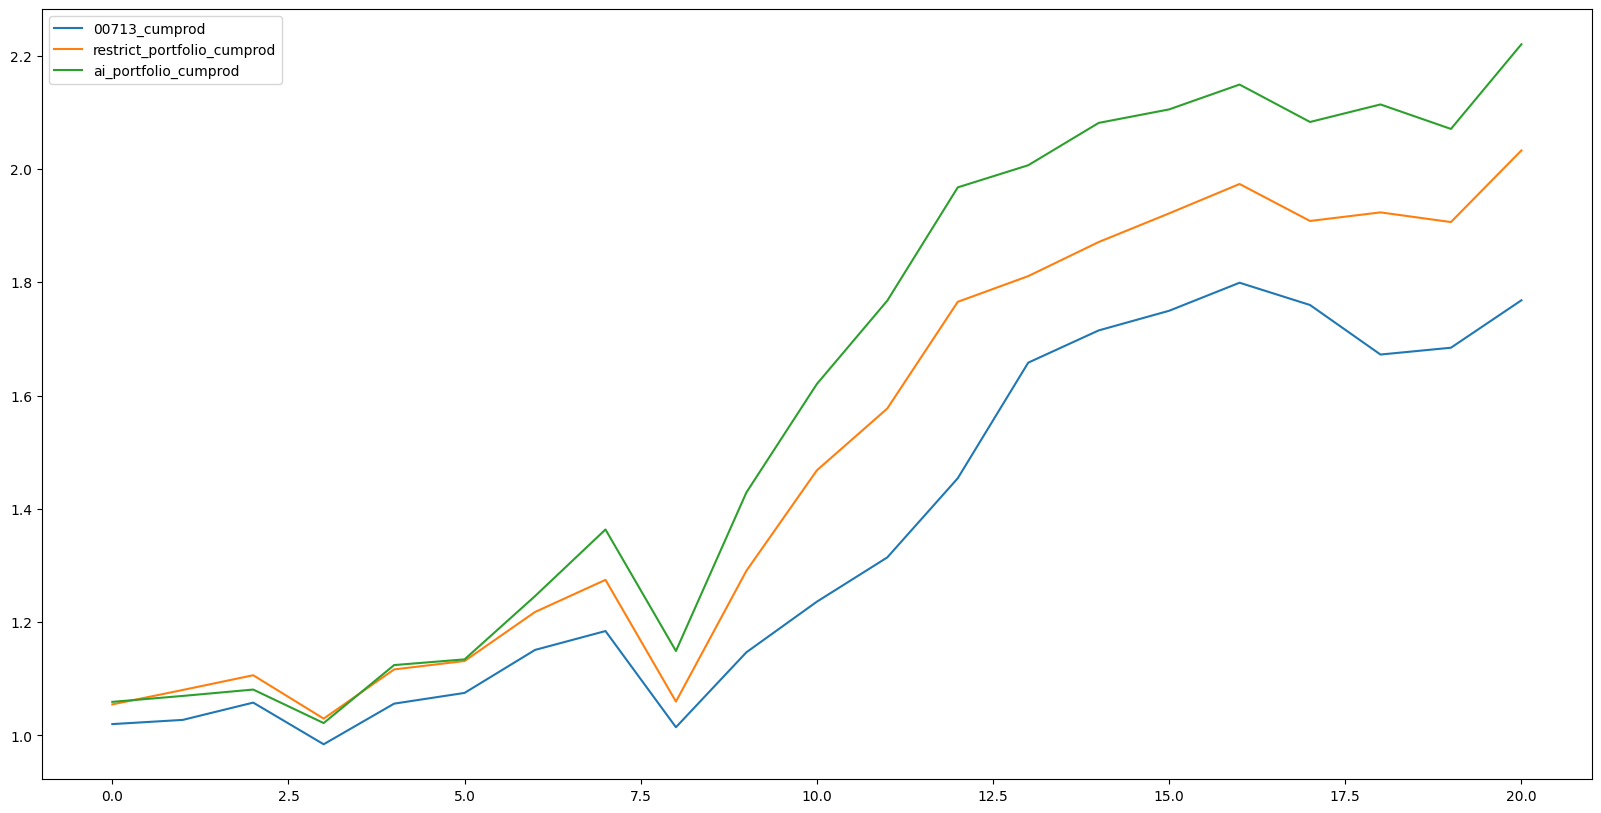

In [141]:
df_benchmarks_temp = df_benchmarks_all[['日期','00713']].copy()
df_benchmarks_temp.columns = ['date','00713']
df_benchmarks_temp.dropna(inplace=True)
# change the date format to datetime
df_benchmarks_temp['date'] = pd.to_datetime(df_benchmarks_temp['date'], format='%Y/%m/%d')
df_benchmarks_temp.sort_values('date', inplace=True)
df_benchmarks = pd.merge(df_rebalance_date, df_benchmarks_temp, on='date', how='left')

df_benchmarks.dropna(inplace=True)
df_benchmarks.reset_index(drop=True, inplace=True)
df_benchmarks['00713_adj'] = df_benchmarks['00713'] / df_benchmarks['00713'].iloc[0]
df_benchmarks['00713'] = df_benchmarks['00713'].astype(float)
# shift -1 for calculate the return
df_benchmarks['00713_shift'] = df_benchmarks['00713'].shift(-1)
df_benchmarks['00713_return'] = df_benchmarks['00713_shift'] / df_benchmarks['00713']

df_benchmarks = df_benchmarks.merge(df_restrict_portfolio, on='date', how='left')
df_benchmarks = df_benchmarks.merge(df_portfolio, on='date', how='left')
df_benchmarks['00713_cumprod'] = df_benchmarks['00713_return'].cumprod()
df_benchmarks['restrict_portfolio_cumprod'] = df_benchmarks['restrict_portfolio'].cumprod()
df_benchmarks['ai_portfolio_cumprod'] = df_benchmarks['ai_portfolio'].cumprod()

df_benchmarks[['00713_cumprod','restrict_portfolio_cumprod','ai_portfolio_cumprod']].plot(figsize=(20,10))

<Axes: >

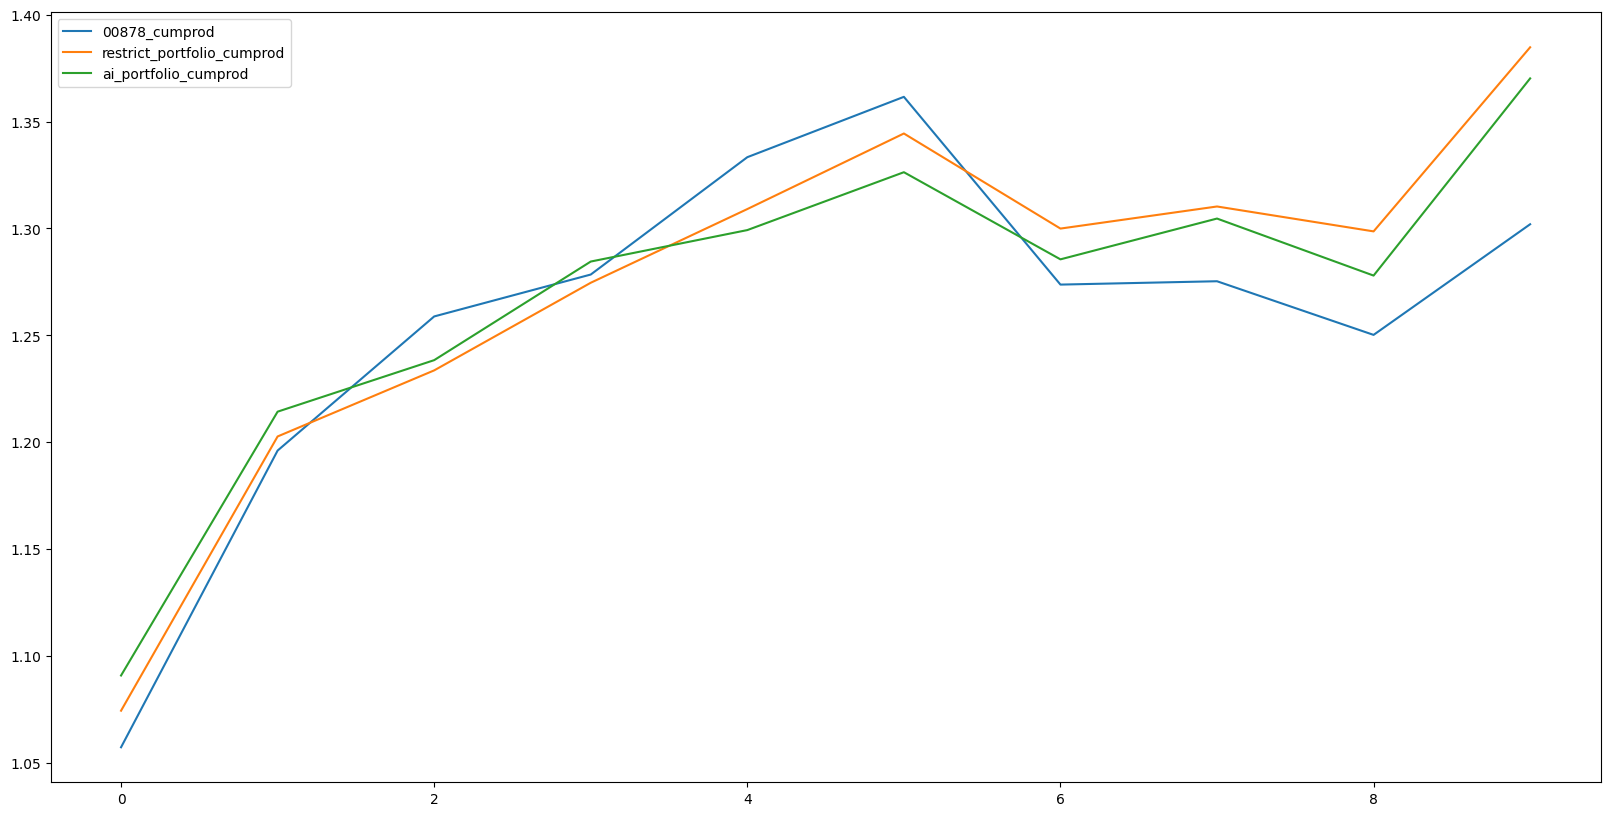

,date,00878,00878_shift,00878_rebalance_period_return
0,2020-09-15,12.7500,13.4800,0.0573
1,2020-12-15,13.4800,15.2500,0.1313
2,2021-03-15,15.2500,16.0500,0.0525
3,2021-06-15,16.0500,16.3000,0.0156
4,2021-09-15,16.3000,17.0000,0.0429
5,2021-12-15,17.0000,17.3600,0.0212
6,2022-03-15,17.3600,16.2400,-0.0645
7,2022-06-15,16.2400,16.2600,0.0012
8,2022-09-15,16.2600,15.9400,-0.0197
9,2022-12-15,15.9400,16.6000,0.0414


In [93]:
df_select_filter_dividends_yield_top_50_return

date
2005-03-15   -0.0065
2005-06-15    0.0531
2005-09-15    0.0450
2005-12-15    0.0107
2006-03-15    0.0543
2006-06-15    0.0868
2006-09-15    0.1740
2006-12-15    0.1118
2007-03-15    0.1303
2007-06-15    0.1257
2007-09-17   -0.1296
2007-12-17    0.0632
2008-03-17    0.0136
2008-06-16   -0.2411
2008-09-15   -0.1641
2008-12-15    0.1536
2009-03-16    0.2278
2009-06-15    0.2397
2009-09-15    0.0901
2009-12-15   -0.0205
2010-03-15   -0.0154
2010-06-15    0.1059
2010-09-15    0.0697
2010-12-15   -0.1086
2011-03-15    0.1011
2011-06-15   -0.0969
2011-09-15   -0.0910
2011-12-15    0.2680
2012-03-15   -0.0886
2012-06-15    0.1453
2012-09-17   -0.0214
2012-12-17    0.0762
2013-03-15    0.0333
2013-06-17    0.1132
2013-09-16    0.0330
2013-12-16    0.0824
2014-03-17    0.0926
2014-06-16   -0.0174
2014-09-15   -0.0455
2014-12-15    0.0749
2015-03-16   -0.0672
2015-06-15   -0.0753
2015-09-15    0.0158
2015-12-15    0.0787
2016-03-15    0.0151
2016-06-15    0.0979
2016-09-19    0.0341
2016-12-

# Consider Turnover

In [62]:
apply_buffer_index = 0
base_portfolio_number = 50
buffer_portfolio_number = 150

In [63]:
df_select_pool = df_select_pool.reset_index(drop=True)
# get the base portfolio by base_portfolio_number 
df_select_pool_base = df_select_pool.groupby('date').apply(top_n, n = base_portfolio_number, columns=['predict_rank'], ascending=[True]).reset_index(drop=True)
# get the buffer portfolio by buffer_portfolio_number
df_select_pool_buffer = df_select_pool.groupby('date').apply(top_n, n = buffer_portfolio_number, columns=['predict_rank'], ascending=[True]).reset_index(drop=True)
df_select_pool_buffer.reset_index(drop=True, inplace=True)


apply_buffer_date = np.sort(reb_lst)[apply_buffer_index]
# string format
apply_buffer_date = pd.to_datetime(apply_buffer_date).strftime('%Y-%m-%d')
print(f'自 {apply_buffer_date} 開始使用 buffer 建構投組')

df_buffer_result = pd.DataFrame([])
# concat the data that date is smaller than apply_buffer_date to df_buffer_result
df_buffer_result = pd.concat([df_buffer_result, df_select_pool_base[df_select_pool_base['date'] < apply_buffer_date]], axis=0)
# print the max date in df_buffer_result
print(f"df_buffer_result['date'].max(): {df_buffer_result['date'].max()}")

for i in range(apply_buffer_index, len(reb_lst)):
    # get the slice data by reb_lst[i] in df_select_pool_buffer
    df_select_pool_buffer_temp = df_select_pool_buffer[df_select_pool_buffer['rebalance_date'] == reb_lst[i]].reset_index(drop=True)
    # get the slice data by reb_lst[i-1] in df_buffer_result, [i-1] is because we need to get the last portfolio
    df_buffer_result_temp = df_buffer_result[df_buffer_result['rebalance_date'] == reb_lst[i - 1]].reset_index(drop=True)

    # prepare the dataframe for finding the joint ticker
    df_new_temp = df_select_pool_buffer_temp[['date','ticker']].copy()
    df_new_temp['buffer'] = 1
    df_old_temp = df_buffer_result_temp[['date','ticker']].copy()
    df_old_temp['last_portfolio'] = 1

    # merge the df_old_temp and df_new_temp
    df_joint_temp = pd.merge(df_old_temp[['ticker','last_portfolio']], df_new_temp[['ticker','buffer']], on=['ticker'], how='outer')
    df_joint_temp['buffer'].fillna(0, inplace=True)
    df_joint_temp['last_portfolio'].fillna(0, inplace=True)
    df_joint_temp['total'] = df_joint_temp['buffer'] + df_joint_temp['last_portfolio']
    df_joint_temp = df_joint_temp[df_joint_temp['total'] == 2]

    # get the joint ticker
    joint_ticker = df_joint_temp['ticker'].unique()

    # get the priority portfolio by joint_ticker
    df_priority = df_select_pool_buffer_temp[df_select_pool_buffer_temp['ticker'].isin(joint_ticker)]
    # get the triviality portfolio by EXCLUDING joint_ticker
    df_triviality = df_select_pool_buffer_temp[df_select_pool_buffer_temp['ticker'].isin(joint_ticker) == False]
    # then find the (top n - len(df_priority)) number of stocks triviality portfolio
    df_triviality = df_triviality.groupby('date').apply(top_n, n = base_portfolio_number - len(df_priority), columns=['predict_rank'], ascending=[True]).reset_index(drop=True)
    
    # concat the df_priority and df_triviality
    df_buffer_result_temp = pd.concat([df_priority, df_triviality], axis=0)

    # concat the df_buffer_result_temp to df_buffer_result
    df_buffer_result = pd.concat([df_buffer_result, df_buffer_result_temp], axis=0)

df_buffer_result.reset_index(drop=True, inplace=True)
# df_buffer_result_return = df_buffer_result.groupby('date')['y'].mean()
df_buffer_result_return = df_buffer_result.groupby('date')['rebalance_period_return'].mean()

df_buffer_result.to_feather(f'./data/model/{model_folder_name}/df_buffer_result_{apply_buffer_index}_{base_portfolio_number}_{buffer_portfolio_number}.feather')
print(f"SR: {((df_buffer_result_return + 1).prod()**(4/len(df_buffer_result_return)) -1 ) / (df_buffer_result_return.std() * np.sqrt(4)):.2f}")
# Assuming your DataFrame is named df_returns
cagr = calculate_cagr(df_buffer_result_return)
print(f"CAGR: {cagr:.2%}")
print(f"Std: {(df_buffer_result_return.std() * np.sqrt(4)):.2%}")

自 2005-03-15 開始使用 buffer 建構投組
df_buffer_result['date'].max(): NaT
SR: 0.66
CAGR: 12.23%
Std: 18.50%
